# Gantt Generator

Get data from a simple Excel Sheet and build a Gantt Chart 

In [107]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

# https://pypi.org/project/python-gantt/
import gantt


In [108]:
# Vars and configurations

filename = 'project_example_source.xlsx'
MAIN_PROJECT = 'MAIN PROJECT'

# Day in Brazil (Latin América) format
today = datetime.datetime.today().strftime('%Y-%m-%d')

pie_size = (8, 8)
barh_size = (16, 8)
colors = ['yellow', 'lime', 'red', 'orange', 'green', 'gray', 'aqua']

# Load tasks records and holidays
data = pd.read_excel(filename, sheet_name='Project')
data_holidays = pd.read_excel(filename, sheet_name='Holidays')
holidays = list(data_holidays.Day)

# Change font default
gantt.define_font_attributes(fill='black', stroke='black', stroke_width=0, font_family="Carlito")


## Functions

In [109]:

# Get records with date (start_date | forecast | accomplished) equal or after current date
def records_with_date_after_today_by(_field):
    return data.loc[(data[_field] >= today)].copy()

# Get records with date (start_date | forecast | accomplished) equal or before current date
def records_with_date_before_today_by(_field):
    return data.loc[(data[_field] < today)].copy()

# Delayed records
def delayed_records():
    field = 'forecast'
    return data.loc[(data[field] < today) & (data['pct_progress'] < 100)].copy()

# Records with 'accomplished' date not 'NaT' and 'pct_progress = 100
def accomplished_records():
    return data.loc[(data['accomplished'].notna()) & (data['pct_progress'] == 100)].copy()

# Records whose 'pct_progress' isn't zero (not started), but isn't 100 (not accomplished)
def records_in_progress():
    return data.loc[(data['pct_progress'] > 0) & (data['pct_progress'] < 100) & (data['accomplished'] <= today)].copy()

# Inconsistents records
def inconsistens_records():
    return data.loc[(data['start_date'] > data['forecast'])].copy()

# Add resources to Gantt
def add_resources(_resources):
    result = []
    for name in _resources:
        result.append(gantt.Resource(name))

# Get a filename using a source name and datetime 
def get_filename(_name):
    now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    _name = _name.lower().replace(' ', '_').replace('.', '_')
    return f'{_name}_{now}.svg'

# Get a tasks list (Gantt objects)
def get_tasks(_data, _color):
    tasks = []
    codes = []
    try:
        for item in _data.iterrows():
            codes.append(item[1]['id'])
            tasks.append(gantt.Task( \
                name=item[1]['task'], \
                fullname=f"{item[1]['id']} - {item[1]['task']}", \
                start=pd.Timestamp(item[1]['start_date']), \
                duration=item[1]['days'], \
                percent_done=item[1]['pct_progress'], \
                color=_color, \
                resources=[gantt.Resource(item[1]['external_owner'])] ))
    except KeyError:
        raise Exception('An keyerror type occurs')
    finally:
        print(f"Tasks to {item[1]['source']} processed ok")
        
    result = process_dependencies(list(zip(codes, tasks)))
    return result
    
# Process all dependencies (depends_of) from a tasks set
def process_dependencies(_tasks:list):
    result = []
    for task_id, task_obj in _tasks:
        # get dependencies (objects lists)
        task_obj.depends_of = get_dependencies(task_id, _tasks)
        result.append((task_id, task_obj))
        
    return result

# Get an object (gantt) list with tasks that depends of current task (by 'id')
def get_dependencies(_id, _tasks):
    try:
        dependencies = str(data.loc[data['id'] == _id].values[0][1]).split(';')
        result = []
        for task_id, task_obj in _tasks:
            if str(task_id) in dependencies:
                result.append(task_obj)
        return result
    except:
        raise Exception("Exception in 'get_dependencies' function")

# Get a task by id
def get_task_by_code(_id_find, _task_list:list):
    for _task in _task_list:
        if _task[0] == _id_find:
            return _task[1]
        
    return None

## Build Gantt Chart

1. To each source
2. Full, with all sources

In [110]:
# Add holidays
for day in list(data_holidays.Day):
    gantt.add_vacations(day)

In [111]:
# Adding resources
add_resources(list(data.external_owner.unique()))


In [112]:
# Split sources and build gantts charts

projects = []

for _name in list(data.source.unique()):
    source = _name.upper().replace(' ', '_').replace(' ', '')
    filename = get_filename(_name)
    data_source = data.loc[(data.source == _name)]
    color = random.choice(colors)
    tasks = get_tasks(data_source, color)
    
    # Create a project
    try:
        proj = gantt.Project(name=source)
        for (cod, t) in tasks:
            proj.add_task(t)
    except KeyError:
        raise Exception('An error processing task')
    finally:
        print(f'All tasks from {source} where processed and added to new project')

    projects.append(proj)
    proj.make_svg_for_tasks(filename=f'./gantts/{filename}')

full = gantt.Project(name=MAIN_PROJECT)
for prj in projects:
    full.add_task(prj)

full.make_svg_for_tasks(filename='./gantts/full.svg')

Tasks to SOURCE1 processed ok
All tasks from SOURCE1 where processed and added to new project
Tasks to SOURCE2 processed ok
All tasks from SOURCE2 where processed and added to new project
Tasks to SOURCE3 processed ok
All tasks from SOURCE3 where processed and added to new project
Tasks to SOURCE4 processed ok
All tasks from SOURCE4 where processed and added to new project
Tasks to SOURCE5 processed ok
All tasks from SOURCE5 where processed and added to new project
Tasks to SOURCE6 processed ok
All tasks from SOURCE6 where processed and added to new project
Tasks to SOURCE7 processed ok
All tasks from SOURCE7 where processed and added to new project


## Functions and filters

In [113]:
records = inconsistens_records()
if len(records) > 0: 
    records.head()
else:
    print("No inconsistencies")

No inconsistencies


In [114]:
# Some differences and delays

date_type = 'datetime64[D]'

ins_date = np.array(data['start_date'].values.astype(date_type))
forecast_date = np.array(data['forecast'].values.astype(date_type))
accomplished_date = np.array(data['accomplished'].values.astype(date_type))

try:
    # Diff between init date and forecast date
    data['diff'] = np.busday_count(ins_date, forecast_date)

    # Diff between forecast date and accomplished date
    data['delay'] = np.busday_count(forecast_date, accomplished_date)

    display(data[['task', 'diff', 'delay']].head())
except ValueError:
    raise Exception()



,task,diff,delay
0,Task 01,0,3
1,Task 02,3,0
2,Task 03,4,0
3,Task 04,1,0
4,Task 05,2,0


In [115]:
for row in data.iterrows():
    try:
        if not np.isnat(np.datetime64(row[1]['forecast'])) \
            and not np.isnat(np.datetime64(row[1]['accomplished'])):
                dates = pd.bdate_range(row[1]['forecast'], \
                        row[1]['accomplished'], \
                        freq='C', holidays=holidays)
                print(row[1], len(dates))
    except TypeError:
        raise Exception()


id                                  0
depends_of                        NaN
start_date        2023-03-27 00:00:00
source                        SOURCE1
internal_owner           Marcus Smith
external_owner           Marcus Smith
task                          Task 01
days                                0
forecast          2023-03-27 00:00:00
accomplished      2023-03-30 00:00:00
pct_progress                      100
diff                                0
delay                               3
Name: 0, dtype: object 4
id                                  1
depends_of                          0
start_date        2023-03-30 00:00:00
source                        SOURCE1
internal_owner               Jhon Doe
external_owner           Simone Evans
task                          Task 02
days                                3
forecast          2023-04-04 00:00:00
accomplished      2023-04-04 00:00:00
pct_progress                       80
diff                                3
delay                    

In [116]:
fields = ['start_date', 'forecast', 'accomplished']
for _field in fields:
    print(f"Records with date before today, by '{_field}'")
    display(records_with_date_before_today_by(_field))

    print(f"Records with date after today, by '{_field}'")
    display(records_with_date_after_today_by(_field))
    

Records with date before today, by 'start_date'


,id,depends_of,start_date,source,internal_owner,external_owner,task,days,forecast,accomplished,pct_progress,diff,delay
0,0,NaN,2023-03-27,SOURCE1,Marcus Smith,Marcus Smith,Task 01,0,2023-03-27,2023-03-30,100,0,3
1,1,0,2023-03-30,SOURCE1,Jhon Doe,Simone Evans,Task 02,3,2023-04-04,2023-04-04,80,3,0
2,2,1,2023-04-04,SOURCE1,Jhon Doe,Kalvin Rogers,Task 03,3,2023-04-10,2023-04-10,0,4,0
6,6,1,2023-04-04,SOURCE1,Marcus Smith,Juan Eduardo Fernández,Task 07,2,2023-04-06,2023-04-06,0,2,0
14,14,NaN,2023-04-06,SOURCE2,Jhon Doe,Marisa Heidegger,Task 15,6,2023-04-17,2023-04-17,70,7,0
17,17,14,2023-04-06,SOURCE2,Jhon Doe,Regerio Moraes,Task 18,2,2023-04-11,2023-04-11,20,3,0
23,23,NaN,2023-03-31,SOURCE4,Jhon Doe,Simone Carminatti,Task 24,6,2023-04-11,2023-04-11,70,7,0
24,24,NaN,2023-03-31,SOURCE4,Vivian Grey,Lucia Cappello,Task 25,3,2023-04-05,2023-04-04,100,3,-1
25,25,NaN,2023-03-31,SOURCE5,Marcus Smith,Ismael Ferraz,Task 26,5,2023-04-10,2023-04-10,60,6,0
26,26,NaN,2023-04-05,SOURCE6,Vivian Grey,Marisa Heidegger,Task 27,2,2023-04-10,2023-04-10,80,3,0


Records with date after today, by 'start_date'


,id,depends_of,start_date,source,internal_owner,external_owner,task,days,forecast,accomplished,pct_progress,diff,delay
3,3,2,2023-04-10,SOURCE1,Jhon Doe,William Anderson,Task 04,1,2023-04-11,2023-04-11,0,1,0
4,4,3,2023-04-11,SOURCE1,Jhon Doe,Erika Quiñones,Task 05,2,2023-04-13,2023-04-13,0,2,0
5,5,4,2023-04-13,SOURCE1,Jhon Doe,Fábio Popper,Task 06,4,2023-04-19,2023-04-19,0,4,0
7,7,5,2023-04-19,SOURCE1,Jhon Doe,Waldison Kramer,Task 08,5,2023-04-27,2023-04-27,0,6,0
8,8,7,2023-04-27,SOURCE1,Jhon Doe,Simone Carminatti,Task 09,0,2023-04-27,2023-04-27,0,0,0
9,9,8,2023-04-27,SOURCE1,Jhon Doe,Simone Carminatti,Task 10,20,2023-05-26,2023-05-26,0,21,0
10,10,9,2023-05-26,SOURCE1,Jhon Doe,Leonardo Santos,Task 11,10,2023-06-12,2023-06-12,0,11,0
11,11,10,2023-06-12,SOURCE1,Jhon Doe,Marisa Heidegger,Task 12,10,2023-06-26,2023-06-26,0,10,0
12,12,9,2023-05-26,SOURCE1,Jhon Doe,Tools Team,Task 13,15,2023-06-19,2023-06-19,0,16,0
13,13,8;11,2023-06-26,SOURCE1,Jhon Doe,Marisa Heidegger,Task 14,10,2023-07-10,2023-07-10,0,10,0


Records with date before today, by 'forecast'


,id,depends_of,start_date,source,internal_owner,external_owner,task,days,forecast,accomplished,pct_progress,diff,delay
0,0,NaN,2023-03-27,SOURCE1,Marcus Smith,Marcus Smith,Task 01,0,2023-03-27,2023-03-30,100,0,3
1,1,0,2023-03-30,SOURCE1,Jhon Doe,Simone Evans,Task 02,3,2023-04-04,2023-04-04,80,3,0
6,6,1,2023-04-04,SOURCE1,Marcus Smith,Juan Eduardo Fernández,Task 07,2,2023-04-06,2023-04-06,0,2,0
24,24,NaN,2023-03-31,SOURCE4,Vivian Grey,Lucia Cappello,Task 25,3,2023-04-05,2023-04-04,100,3,-1


Records with date after today, by 'forecast'


,id,depends_of,start_date,source,internal_owner,external_owner,task,days,forecast,accomplished,pct_progress,diff,delay
2,2,1,2023-04-04,SOURCE1,Jhon Doe,Kalvin Rogers,Task 03,3,2023-04-10,2023-04-10,0,4,0
3,3,2,2023-04-10,SOURCE1,Jhon Doe,William Anderson,Task 04,1,2023-04-11,2023-04-11,0,1,0
4,4,3,2023-04-11,SOURCE1,Jhon Doe,Erika Quiñones,Task 05,2,2023-04-13,2023-04-13,0,2,0
5,5,4,2023-04-13,SOURCE1,Jhon Doe,Fábio Popper,Task 06,4,2023-04-19,2023-04-19,0,4,0
7,7,5,2023-04-19,SOURCE1,Jhon Doe,Waldison Kramer,Task 08,5,2023-04-27,2023-04-27,0,6,0
8,8,7,2023-04-27,SOURCE1,Jhon Doe,Simone Carminatti,Task 09,0,2023-04-27,2023-04-27,0,0,0
9,9,8,2023-04-27,SOURCE1,Jhon Doe,Simone Carminatti,Task 10,20,2023-05-26,2023-05-26,0,21,0
10,10,9,2023-05-26,SOURCE1,Jhon Doe,Leonardo Santos,Task 11,10,2023-06-12,2023-06-12,0,11,0
11,11,10,2023-06-12,SOURCE1,Jhon Doe,Marisa Heidegger,Task 12,10,2023-06-26,2023-06-26,0,10,0
12,12,9,2023-05-26,SOURCE1,Jhon Doe,Tools Team,Task 13,15,2023-06-19,2023-06-19,0,16,0


Records with date before today, by 'accomplished'


,id,depends_of,start_date,source,internal_owner,external_owner,task,days,forecast,accomplished,pct_progress,diff,delay
0,0,NaN,2023-03-27,SOURCE1,Marcus Smith,Marcus Smith,Task 01,0,2023-03-27,2023-03-30,100,0,3
1,1,0,2023-03-30,SOURCE1,Jhon Doe,Simone Evans,Task 02,3,2023-04-04,2023-04-04,80,3,0
6,6,1,2023-04-04,SOURCE1,Marcus Smith,Juan Eduardo Fernández,Task 07,2,2023-04-06,2023-04-06,0,2,0
24,24,NaN,2023-03-31,SOURCE4,Vivian Grey,Lucia Cappello,Task 25,3,2023-04-05,2023-04-04,100,3,-1


Records with date after today, by 'accomplished'


,id,depends_of,start_date,source,internal_owner,external_owner,task,days,forecast,accomplished,pct_progress,diff,delay
2,2,1,2023-04-04,SOURCE1,Jhon Doe,Kalvin Rogers,Task 03,3,2023-04-10,2023-04-10,0,4,0
3,3,2,2023-04-10,SOURCE1,Jhon Doe,William Anderson,Task 04,1,2023-04-11,2023-04-11,0,1,0
4,4,3,2023-04-11,SOURCE1,Jhon Doe,Erika Quiñones,Task 05,2,2023-04-13,2023-04-13,0,2,0
5,5,4,2023-04-13,SOURCE1,Jhon Doe,Fábio Popper,Task 06,4,2023-04-19,2023-04-19,0,4,0
7,7,5,2023-04-19,SOURCE1,Jhon Doe,Waldison Kramer,Task 08,5,2023-04-27,2023-04-27,0,6,0
8,8,7,2023-04-27,SOURCE1,Jhon Doe,Simone Carminatti,Task 09,0,2023-04-27,2023-04-27,0,0,0
9,9,8,2023-04-27,SOURCE1,Jhon Doe,Simone Carminatti,Task 10,20,2023-05-26,2023-05-26,0,21,0
10,10,9,2023-05-26,SOURCE1,Jhon Doe,Leonardo Santos,Task 11,10,2023-06-12,2023-06-12,0,11,0
11,11,10,2023-06-12,SOURCE1,Jhon Doe,Marisa Heidegger,Task 12,10,2023-06-26,2023-06-26,0,10,0
12,12,9,2023-05-26,SOURCE1,Jhon Doe,Tools Team,Task 13,15,2023-06-19,2023-06-19,0,16,0


In [117]:
# Delayed records

display(delayed_records())

,id,depends_of,start_date,source,internal_owner,external_owner,task,days,forecast,accomplished,pct_progress,diff,delay
1,1,0,2023-03-30,SOURCE1,Jhon Doe,Simone Evans,Task 02,3,2023-04-04,2023-04-04,80,3,0
6,6,1,2023-04-04,SOURCE1,Marcus Smith,Juan Eduardo Fernández,Task 07,2,2023-04-06,2023-04-06,0,2,0


source
SOURCE4    85.000000
SOURCE5    60.000000
SOURCE6    26.666667
SOURCE2    22.500000
SOURCE1    12.857143
SOURCE7     5.625000
SOURCE3     0.000000
Name: pct_progress, dtype: float64

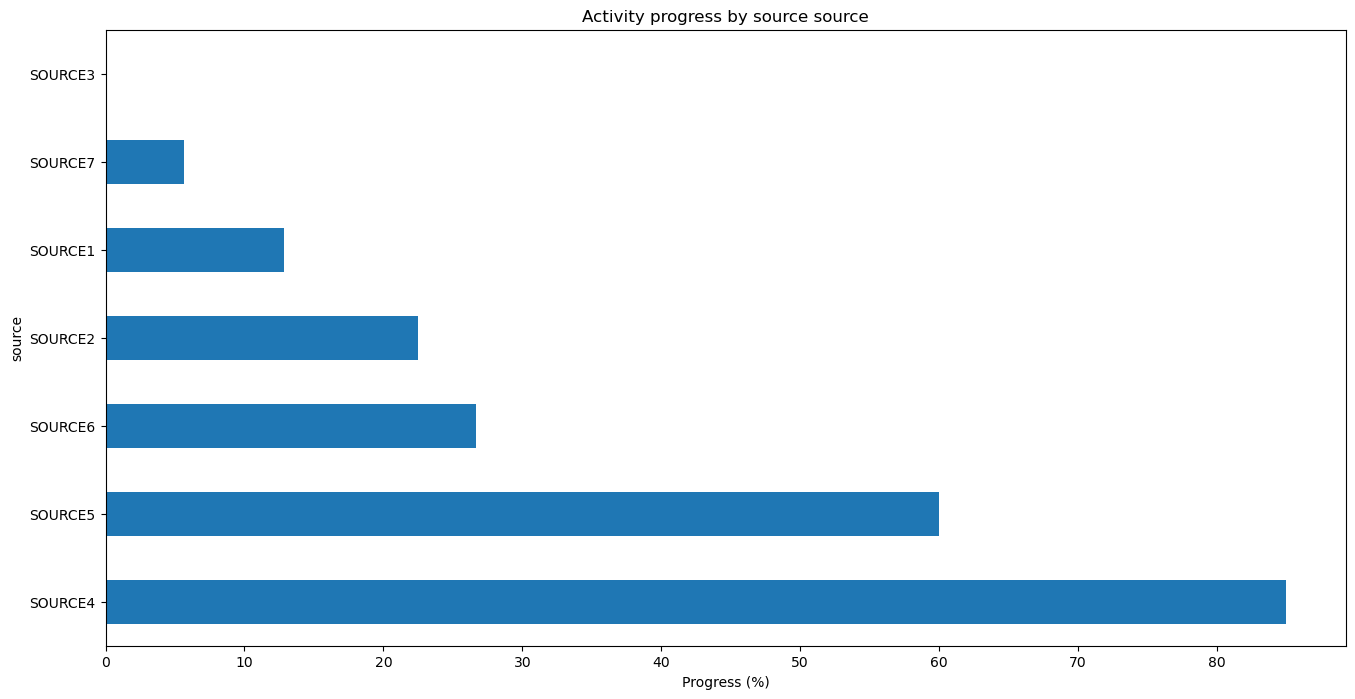

internal_owner
Vivian Grey     45.000000
Marcus Smith    32.000000
Jhon Doe         9.166667
Name: pct_progress, dtype: float64

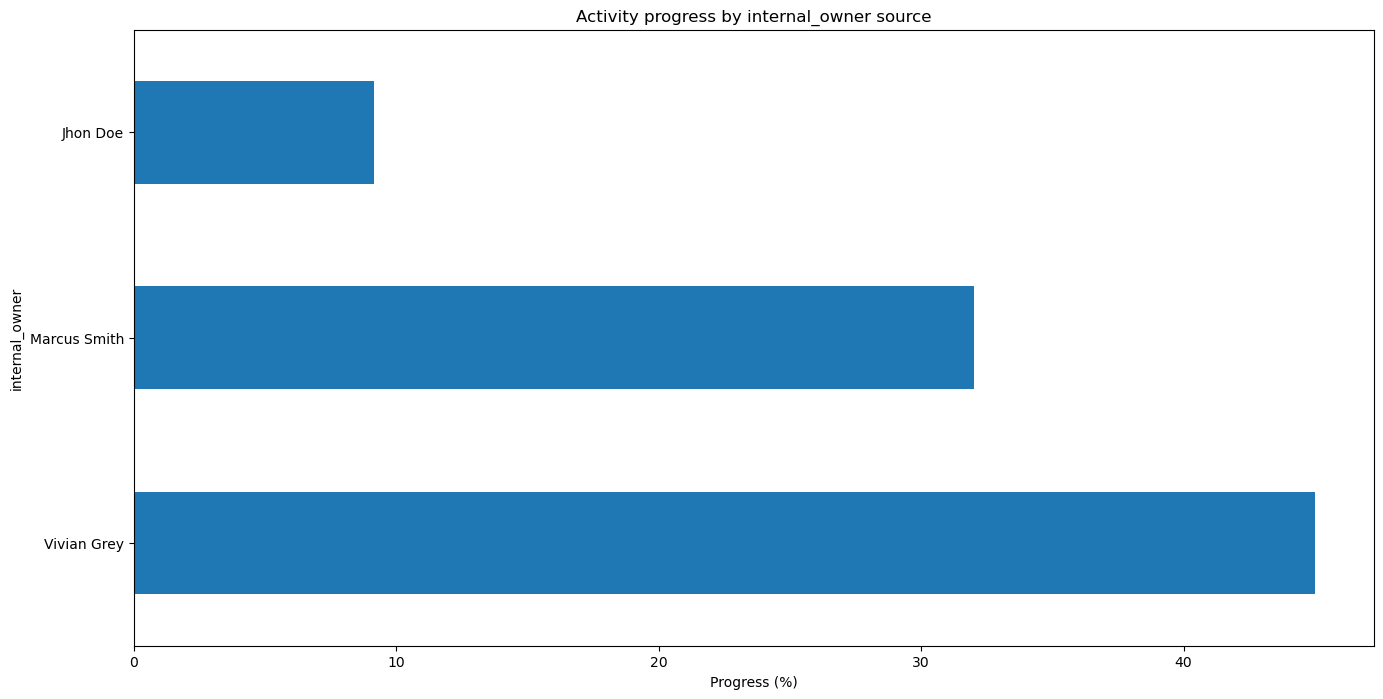

external_owner
Lucia Cappello            100.000000
Marcus Smith              100.000000
Ismael Ferraz              60.000000
Simone Evans               50.000000
Simone Carminatti          23.333333
Jhon Doe                   20.000000
Marisa Heidegger           16.666667
Regerio Moraes              3.333333
Waldison Kramer             0.000000
Tools Team                  0.000000
Origin Source               0.000000
Cassiano dos Santos         0.000000
Erika Quiñones              0.000000
Leonardo Santos             0.000000
Kalvin Rogers               0.000000
Juan Eduardo Fernández      0.000000
Infra Source                0.000000
Fábio Popper                0.000000
William Anderson            0.000000
Name: pct_progress, dtype: float64

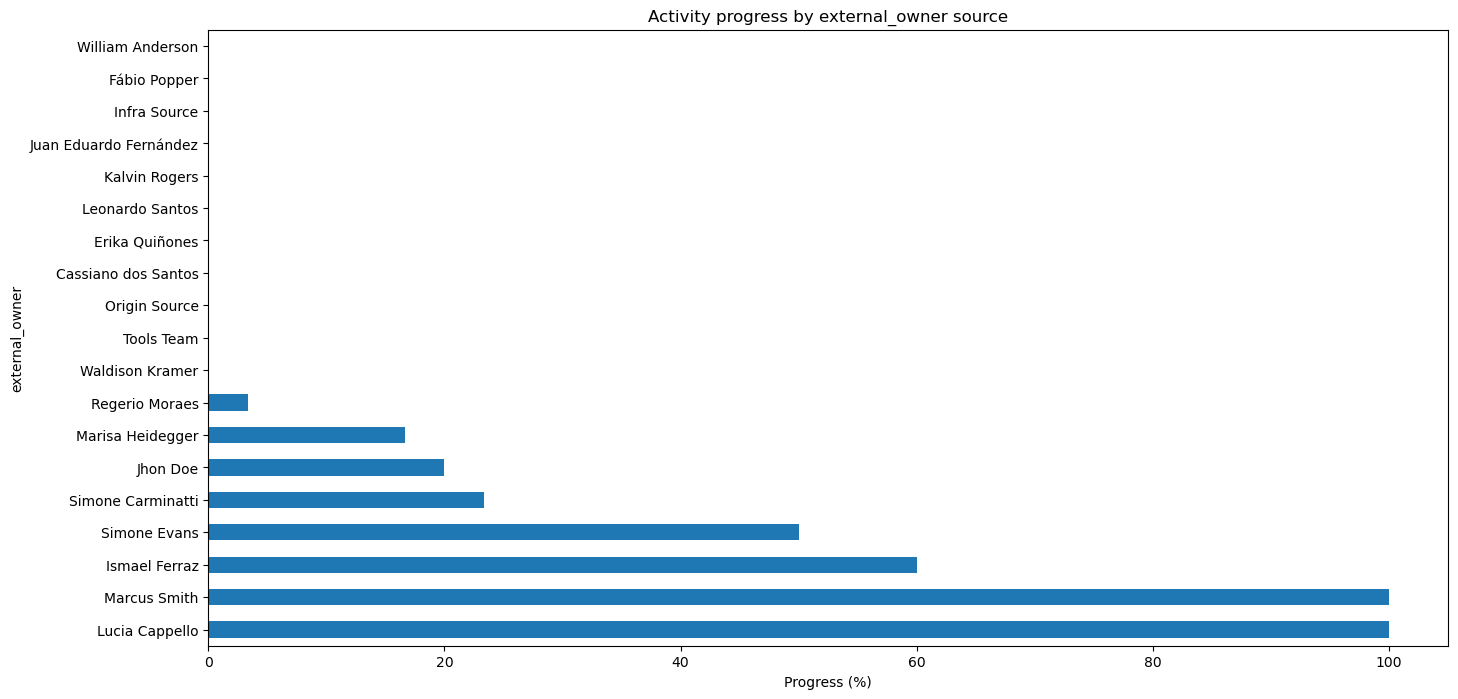

In [118]:
def plot(group):
    sources = data.groupby(group)['pct_progress'].mean().sort_values(ascending=False).copy()
    display(sources)

    ax = sources.plot(kind='barh', title=f'Activity progress by {group} source', figsize=barh_size)
    ax.set_xlabel('Progress (%)')
    plt.show()

plot('source')
plot('internal_owner')
plot('external_owner')

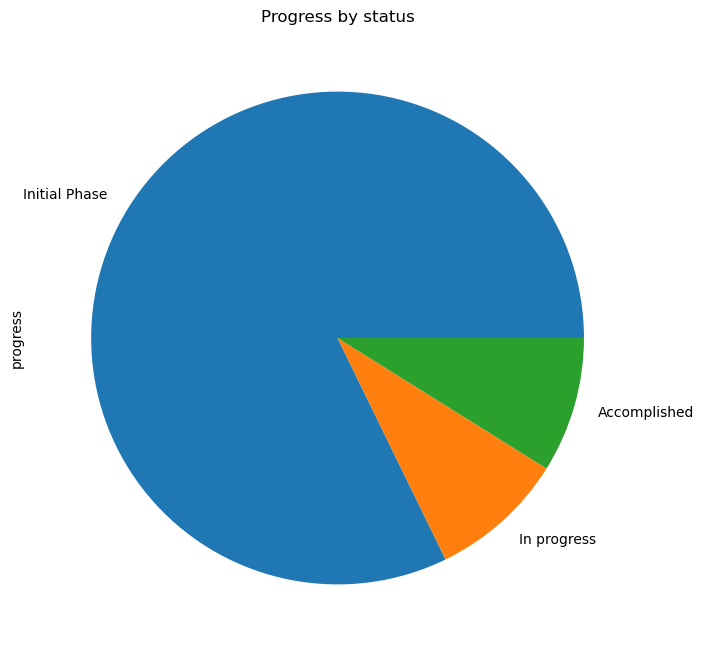

In [119]:
# Categorize tasks by 'pct_progress'
data['progress'] = pd.cut(data.pct_progress, bins=[-1,30, 70, 101], labels=['Initial Phase', 'In progress', 'Accomplished'])
data.groupby('progress')['progress'].count().plot(kind='pie', title='Progress by status', figsize=pie_size)
plt.show()

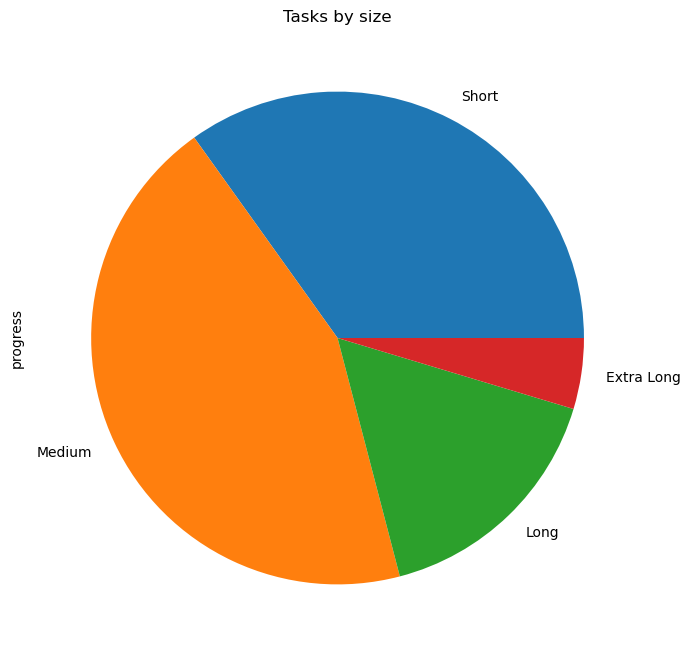

In [120]:
# Categorize by time (just not accomplished taks - not 100%)
data['wip'] = pd.cut(data['diff'], bins=[-1,3,7,15,25,100], 
    labels=['Short', 'Medium', 'Long', 'Extra Long', 'Long Term']).astype('category')

pending = data[data['pct_progress'] != 100].copy()
pending.groupby('wip')['progress'].count().plot(kind="pie", title="Tasks by size", figsize=pie_size)
plt.show()

In [121]:
# Number of tasks by internal owner and accomplished average 
list(data.groupby('internal_owner')[['wip', 'task']]) 
#[['wip']].agg({'wip', 'count'})

[('Jhon Doe',
             wip     task
  1        Short  Task 02
  2       Medium  Task 03
  3        Short  Task 04
  4        Short  Task 05
  5       Medium  Task 06
  7       Medium  Task 08
  8        Short  Task 09
  9   Extra Long  Task 10
  10        Long  Task 11
  11        Long  Task 12
  12  Extra Long  Task 13
  13        Long  Task 14
  14      Medium  Task 15
  15       Short  Task 16
  16      Medium  Task 17
  17       Short  Task 18
  18       Short  Task 19
  19      Medium  Task 20
  21      Medium  Task 22
  22       Short  Task 23
  23      Medium  Task 24
  29      Medium  Task 30
  30      Medium  Task 31
  31       Short  Task 32
  33        Long  Task 34
  34        Long  Task 35
  35       Short  Task 36
  36       Short  Task 37
  37        Long  Task 38
  38      Medium  Task 39
  39      Medium  Task 40
  40      Medium  Task 41
  41      Medium  Task 42
  42      Medium  Task 43
  43      Medium  Task 44
  44        Long  Task 45),
 ('Marcus Smith',
    